<a href="https://colab.research.google.com/github/Rocky12312/Question-Answering-NLP/blob/master/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My\ Drive/Tweet_sentiment_extraction/tasks_1-20_v1-2

/content/drive/My Drive/Tweet_sentiment_extraction/tasks_1-20_v1-2


In [0]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Data file for this notebook we can also find at https://research.fb.com/downloads/babi and then navigating to HITL Dialogue Simulator there is a file names bAbI Tasks Data 1-20 which contains the data used in this notebook and several other useful data

And using the below link we can actually download the data automatically

In [4]:
from keras.utils.data_utils import get_file
import tarfile
#The keras get_file function to just download the data
path = get_file("babi-tasks-v1-2.tar.gz",origin = "https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz")
#Tarfile libraray just takes care of extraction so no need to do it manually
fl = tarfile.open(path)

Using TensorFlow backend.


In [0]:
#Getting only the relavent data qa1 with 10,000 samples and qa2 with 10,000 samples
#Basically this dictionary tell us where the relevan data is
challenges = {"single_supporting_fact_10k":"tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt","two_supporting_fact_10k":"tasks_1-20_v1-2/en-10k/qa2_two-supporting-fact_{}.txt"}

In [0]:
a = "single_supporting_fact_10k"
data_fl = challenges[a]
stories_train = fl.extractfile(data_fl.format("train"))
stories_test = fl.extractfile(data_fl.format("test"))

In [7]:
type(stories_train)

tarfile.ExFileObject

In [0]:
#Running this we can see what our data looks like
#for line in stories_train:
  #print(line)

In [0]:
def tokenize(sent):
  #Here we will be returning tokens including punctuations
  return [x.strip() for x in re.split("(\W+)?",sent) if x.strip()]

Now our main task wil be is to generate three containers from our data file which will contain the questions, answers and the story on whose basis the answer to question should be given and this below get_stories function does this task for us

In [0]:
def get_stories(file):
  #Here we will be storing the questions,answers and the context in data list
  q_a_c_data = []
  #Using story list to keep track of the story so far
  story = []
  printed = False
  for line in file:
    line = line.decode('utf-8').strip()

    #split the line id number number from the rest of the line
    lineid,line = line.split(" ", 1)

    #If the value of our line id is one it means that it is start of new story
    if int(lineid) == 1:
      story = []
    #If we encountered a tab somewhere in line it means that the line contain the question and the answer based on the story so far 
    #and it also contain information like which line is relavent for answer
    if "\t" in line:
      ques,ans,supporting = line.split('\t')
      ques = tokenize(ques)
      #Numbering the lines adding unique tokens in front of each sentence
      story_so_far = [[str(i)] + s for i, s in enumerate(story) if s]
      #Now as we have the story so far the question and the answer we will append all this data in our data
      q_a_c_data.append((story_so_far,ques,ans))
      story.append("")
    else:
      #If we dont have tab in our line what we gonna do is simply append the tokenized line to story list and do this until we get a line
      #in which tab is there
      story.append(tokenize(line))
  return q_a_c_data

In [11]:
data_all = get_stories(stories_train)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


This is what the data look like after appending the questions answers and the context in a q_a_c_data list

There will be a two dimension list for the context sentences(which are tokenized), a tokenized list of the question and a string containing the answer in every story in our data

Now we are having our questions,answers and the context on which these question and answer are based

Recursively flattening as list and this function is really helpful in getting the vocabulary size from the data as our data contains various levels lists

In [0]:
def should_flatten(el):
  return not isinstance(el,(str,bytes))

In [0]:
def flatten(l):
  for el in l:
    if should_flatten(el):
      yield from flatten(el)
    else:
      yield el

THe below function is for vectorizing stories and here we will be vectorizing the data manually without using the tokenizer as our lists are really complicated in structure in this case

In [0]:
def vectorizing_stories(data,word2idx,story_maxlen,query_maxlen):
  inputs,queries,answers = [],[],[]
  for story,query,answer in data:
    #Converting the list of words into list of word indexes
    #Vectorizing the story
    inputs.append([[word2idx[w] for w in s]for s in story])
    #Vectorizing the question(query)
    queries.append([word2idx[w] for w in query])
    #Vectorizing the answer
    answers.append([word2idx[answer]])
    #We are also returning the list of padded sequence insted of initial length sequence based upon story maxlen and query maxlen
  return ([pad_sequences(x,maxlen = story_maxlen) for x in inputs],pad_sequences(queries,maxlen = query_maxlen),np.array(answers))

As earlier from the data we have seen that the stories in the data have different number of sentences so we also need to the pad the stories in such a way that we have same number of sentences in our stories and our all stories have same shape

In [0]:
def stack_inputs(inputs,story_maxsents,story_maxlen):
  for i,story in enumerate(inputs):
    #Here we will be going through all the stories and will pad them such that their shape will bw same as maximum length story
    inputs[i] = np.concatenate([story,np.zeros((story_maxsents-story.shape[0],story_maxlen),"int")])
  return np.stack(inputs)

Now after running all the above function on the data what we will be having is som what good data which have all the stories of same size and all queries of same size 

In [0]:
def get_data(challenge_type):
  #Using the challenge dictionary to get the data either single support or two support
  challenge = challenges[challenge_type]
  train_stories = get_stories(fl.extractfile(challenge.format("train")))
  test_stories = get_stories(fl.extractfile(challenge.format("test")))
  #Appending the train and test stories
  stories = train_stories+test_stories
  #Next we will be needing the maximum story length,maximum sentence length and maximum query length to pad the story and the queries
  #Getting the max story word length(iterating over the stories)
  story_maxlen = max((len(s) for x,_,_ in stories for s in x))
  #Getting the max sentence number from all the stories
  story_maxsents = max((len(x) for x,_,_ in stories))
  #Getting the maximum query length
  query_maxlen = max(len(x) for _,x,_ in stories)
  #Getting the vocabulary using faltten function
  vocab = sorted(set(flatten(stories)))
  #Inserting the <PAD> token in vocabulary
  vocab.insert(0,"<PAD>")
  vocab_size = len(vocab)
  word2idx = {c:i for i,c in enumerate(vocab)}
  #Vectorizing the inputs(story,query and answers)
  input_train,queries_train,answers_train = vectorizing_stories(train_stories,word2idx,story_maxlen,query_maxlen)
  input_test,queries_test,answers_test = vectorizing_stories(test_stories,word2idx,story_maxlen,query_maxlen)
  #Padding the stories(so that all have same length)
  inputs_train = stack_inputs(input_train,story_maxsents,story_maxlen)
  inputs_test = stack_inputs(input_test,story_maxsents,story_maxlen)
  print("inputs_train.shape,inputs_test.shape",inputs_train.shape,inputs_test.shape)
  return train_stories,test_stories,inputs_train,queries_train,answers_train,inputs_test,queries_test,answers_test,story_maxsents,story_maxlen,query_maxlen,vocab,vocab_size

In [17]:
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
train_stories,test_stories,inputs_train,queries_train,answers_train,inputs_test,queries_test,answers_test,story_maxsents,story_maxlen,query_maxlen,vocab,vocab_size = get_data("single_supporting_fact_10k")

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


inputs_train.shape,inputs_test.shape (10000, 10, 8) (1000, 10, 8)


In [18]:
#This is what our data looked like
train_stories[0:5]

[([['0', 'Mary', 'moved', 'to', 'the', 'bathroom', '.'],
   ['1', 'John', 'went', 'to', 'the', 'hallway', '.']],
  ['Where', 'is', 'Mary', '?'],
  'bathroom'),
 ([['0', 'Mary', 'moved', 'to', 'the', 'bathroom', '.'],
   ['1', 'John', 'went', 'to', 'the', 'hallway', '.'],
   ['3', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.'],
   ['4', 'Sandra', 'moved', 'to', 'the', 'garden', '.']],
  ['Where', 'is', 'Daniel', '?'],
  'hallway'),
 ([['0', 'Mary', 'moved', 'to', 'the', 'bathroom', '.'],
   ['1', 'John', 'went', 'to', 'the', 'hallway', '.'],
   ['3', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.'],
   ['4', 'Sandra', 'moved', 'to', 'the', 'garden', '.'],
   ['6', 'John', 'moved', 'to', 'the', 'office', '.'],
   ['7', 'Sandra', 'journeyed', 'to', 'the', 'bathroom', '.']],
  ['Where', 'is', 'Daniel', '?'],
  'hallway'),
 ([['0', 'Mary', 'moved', 'to', 'the', 'bathroom', '.'],
   ['1', 'John', 'went', 'to', 'the', 'hallway', '.'],
   ['3', 'Daniel', 'went', 'back', 'to', 'th

In [19]:
#This is what our stories look like after id imputation and padding etc
inputs_train[0:5]

array([[[ 0,  2, 15, 26, 29, 28, 19,  1],
        [ 0,  3, 14, 31, 29, 28, 22,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0,  2, 15, 26, 29, 28, 19,  1],
        [ 0,  3, 14, 31, 29, 28, 22,  1],
        [ 7, 13, 31, 18, 29, 28, 22,  1],
        [ 0,  8, 16, 26, 29, 28, 21,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]],

       [[ 0,  2, 15, 26, 29, 28, 19,  1],
        [ 0,  3, 14, 31, 29, 28, 22,  1],
        [ 7, 13, 31, 18, 29, 28, 22,  1],
        [ 0,  8, 16, 26, 29, 2

In [20]:
#This is what our queries look like after id imputation and padding
queries_train[0:5]

array([[17, 23, 15, 12],
       [17, 23, 13, 12],
       [17, 23, 13, 12],
       [17, 23, 13, 12],
       [17, 23, 16, 12]], dtype=int32)

In [21]:
#This is what our answers look like after id imputation and padding
answers_train[0:5]

array([[19],
       [22],
       [22],
       [27],
       [19]])

In [22]:
print(story_maxlen)

8


In [23]:
print(story_maxsents)

10


Now we are done with formatting our data in such a way that it has format similar to the one which we can feed to the model

In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation
from keras.optimizers import Adam, RMSprop

Here we will not be using pretrained embeddings and we will allow the embedding
 learn so that it can catch the relation in story and the question to give the answer 

Creating the embedding matrix for both story and the queries

In [25]:
Embedding_dim = 40
input_story = Input((story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size, Embedding_dim)(input_story)
embedded_story = Lambda(lambda x: K.sum(x, axis=2))(embedded_story)
print("Shape of input stories,Shape of embedded stories",input_story.shape,embedded_story.shape)

Shape of input stories,Shape of embedded stories (None, 10, 8) (None, 10, 40)


In [26]:
input_question = Input((query_maxlen,))
embedded_question = Embedding(vocab_size,Embedding_dim)(input_question)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)
embedded_question = Reshape((1, Embedding_dim))(embedded_question)
print("Shape of input queries,Shape of embedded queries",input_question.shape,embedded_story.shape)

Shape of input queries,Shape of embedded queries (None, 4) (None, 10, 40)


Our embedded stories will have a shape of (Vocab_size,max_sents,Embedding_dim)

Our embedded queries will have a shape of (Vocab_size,1,Embedding_dim)

In [27]:
#Getting the dot product of embedded story and the embedded query
x = dot([embedded_story, embedded_question], 2)
x.shape
#What we gonna have will be a matrix of shape (10,1) for each story,question pair after their dot product

TensorShape([None, 10, 1])

In [0]:
 #Flattening the vector
x = Reshape((story_maxsents,))(x)

In [29]:
x = Activation('softmax')(x)
#Unflattening it again to be dotted later
story_weights = Reshape((story_maxsents, 1))(x)
print("story_weights.shape:", story_weights.shape)

story_weights.shape: (None, 10, 1)


In [0]:
x = dot([story_weights, embedded_story], 1)
x = Reshape((Embedding_dim,))(x)
ans = Dense(vocab_size, activation='softmax')(x)

In [0]:
model = Model([input_story, input_question], ans)

In [0]:
model.compile(optimizer=RMSprop(lr=1e-2),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [33]:
# train the model
ht = model.fit([inputs_train, queries_train],answers_train,epochs=20,batch_size=32,validation_data=([inputs_test, queries_test], answers_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 74us/step - loss: 0.4278 - accuracy: 0.8482 - val_loss: 0.0289 - val_accuracy: 0.9890
Epoch 2/20
10000/10000 [==============================] - 1s 58us/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 1.4917e-04 - val_accuracy: 1.0000
Epoch 3/20
10000/10000 [==============================] - 1s 58us/step - loss: 1.4475e-05 - accuracy: 1.0000 - val_loss: 1.0729e-09 - val_accuracy: 1.0000
Epoch 4/20
10000/10000 [==============================] - 1s 56us/step - loss: 1.5497e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/20
10000/10000 [==============================] - 1s 59us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
10000/10000 [==============================] - 1s 59us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
10000/10000 [=========

Plotting the model curves

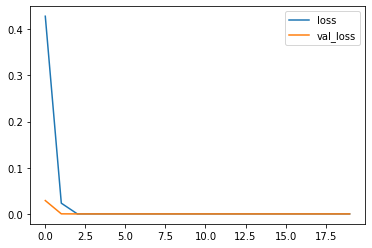

In [34]:
plt.plot(ht.history["loss"],label = "loss")
plt.plot(ht.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()

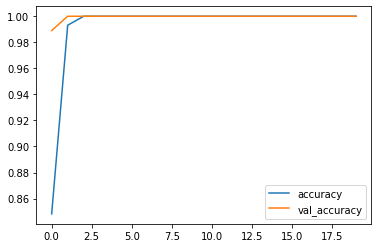

In [35]:
plt.plot(ht.history["accuracy"],label = "accuracy")
plt.plot(ht.history["val_accuracy"],label = "val_accuracy")
plt.legend()
plt.show()

In [0]:
#Checking how we weight each input sentence given a story and question
debugging_model = Model([input_story, input_question], story_weights)

In [0]:
#Choosing a random story for all
story_idx = np.random.choice(len(train_stories))

In [0]:
#Getting the weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w = debugging_model.predict([i, q]).flatten()

In [39]:
story, question, ans = train_stories[story_idx]
print("story is:\n")
for i, line in enumerate(story):
  print("{:1.10f}".format(w[i]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)

story is:

0.0005270375 	 0 John went back to the kitchen .
0.0000000040 	 1 Mary travelled to the garden .
0.9994688630 	 3 John journeyed to the hallway .
0.0000041079 	 4 Sandra moved to the bathroom .
question: Where is John ?
answer: hallway
